<a href="https://colab.research.google.com/github/Giovanni-Chipuli/Churn_Clasif_Despliegue/blob/main/Churn_2_Evaluaci%C3%B3n_Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación de los Datos

Se resumen las configuraciones y tratamientos del primer cuaderno, hasta la separación de los datasets de entrenamiento y prueba.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'https://raw.githubusercontent.com/big-gio/02.Clasif_Despliegue-Bank_Churn/main/Archivos/Churn_Modelling.csv'
cm = pd.read_csv(file_path)

id = 'CustomerId'
target = 'Exited'
var_predict = list(set(cm.columns)-{'RowNumber', 'Surname'} - {target, id})

#tabla única
cmTU = cm[[id]+var_predict+[target]]

#Tratamiento de los datos categóricos
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cmTU['Gender'])
cmTU['Gender'] = le.transform(cmTU['Gender'])
le.fit(cmTU['Geography'])
cmTU['Geography'] = le.transform(cmTU['Geography'])

#tratamiento de datos. Normalización
cmTU_esc = cmTU[['Age', 'EstimatedSalary', 'Balance', 'CreditScore']].copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(cmTU_esc)
cmTU_esc2 = scaler.transform(cmTU_esc)

cmTU_esc2 = pd.DataFrame(cmTU_esc2)         #se convierte la matriz en DataFrame
cmTU_esc2.columns= ['Age_esc', 'EstimatedSalary_Esc', 'Balance_esc', 'CreditScore_esc']   #se renombran las columnas que estaban como 0, 1, 2 y 3
cmTU2 = pd.concat([cmTU, cmTU_esc2], axis= 1)           #se juntan la tabla original con la tabla con los datos normalizados
cmTU2.drop(['Age', 'EstimatedSalary', 'Balance', 'CreditScore'], axis = 'columns', inplace= True)       #se eliminan los campos repetidos (variables antes de la normalización)

#tratamiento de datos. Atípicos
var_out = ['Age_esc', 'CreditScore_esc', 'NumOfProducts']
for col in var_out:
  p25= cmTU2[col].describe()['25%']
  p75= cmTU2[col].describe()['75%']
  IQR= p75 - p25
  minbox = p25-(1.5*IQR)
  maxbox = p75+(1.5*IQR)
  cmTU2[col] = cmTU2[col].apply(lambda x: minbox if x<minbox else x)
  cmTU2[col] = cmTU2[col].apply(lambda x: maxbox if x>maxbox else x)

#nueva var_predict
var_predict = list(set(cmTU2.columns)-{target, id})

#se guardan las var_predict como X
#se guarda la variable objetivo "Exited" como y
X = cmTU2[var_predict]
y = cmTU2[target]

#separación de los datos: train y test
#se deja un 70% de los datos para el entrenamiento y un 30% para la prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 123)

<ipython-input-1-3f0b47cd3a08>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmTU['Gender'] = le.transform(cmTU['Gender'])
<ipython-input-1-3f0b47cd3a08>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmTU['Geography'] = le.transform(cmTU['Geography'])


In [2]:
cmTU2.head()

,CustomerId,Tenure,IsActiveMember,Gender,Geography,HasCrCard,NumOfProducts,Exited,Age_esc,EstimatedSalary_Esc,Balance_esc,CreditScore_esc
0,15634602,2,1,0,0,1,1.0,1,0.293517,0.021886,-1.225848,-0.326221
1,15647311,1,1,0,2,0,1.0,0,0.198164,0.216534,0.117350,-0.440036
2,15619304,8,0,0,0,1,3.0,1,0.293517,0.240687,1.333053,-1.536794
3,15701354,1,0,0,0,0,2.0,0,0.007457,-0.108918,-1.225848,0.501521
4,15737888,2,1,0,2,1,1.0,0,0.388871,-0.365276,0.785728,2.063884


#Training Pipeline

In [4]:
from sklearn.linear_model import LogisticRegression #la regresión logística la dejamos tal cual. En el ejercicio pasado todo se dejó por defecto y no se optiminzó ningún hiperparámetro
from sklearn.tree import DecisionTreeClassifier #para el árbol de decisión, se llegó a la conclusión de que el mejor modelo fue optimizando el max_depth = 5
from sklearn.ensemble import RandomForestClassifier #mejor modelo con n_estimators = 6
from sklearn.svm import SVC   #mejor modelo con kernel = 'rbf',  pero 'rbf' es el valor por defecto. No se tiene que poner

models_list_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SVC']
models_list_object = [LogisticRegression(), DecisionTreeClassifier(max_depth = 5), RandomForestClassifier(n_estimators= 6), SVC(kernel = 'rbf')]
models_list_object

[LogisticRegression(),
 DecisionTreeClassifier(max_depth=5),
 RandomForestClassifier(n_estimators=6),
 SVC()]

In [5]:
from sklearn import metrics

model_accu = []
for model in models_list_object:
  model.fit(X_train, y_train)                                   #entrena cada modelo
  y_pred = model.predict(X_test)                                #predice las y con cada modelo
  model_accu.append(metrics.accuracy_score(y_test, y_pred))     #calcula el éxito de cada modelo y lo guarda en la lista

In [6]:
pd.DataFrame({'Models':models_list_name, 'Accuracy':model_accu})

,Models,Accuracy
0,LogisticRegression,0.819000
1,DecisionTreeClassifier,0.860333
2,RandomForestClassifier,0.848333
3,SVC,0.817000


#Métricas de Evaluación

Se tomó como punto de partida el modelo de ***árboles de decisión***.

##Matriz de Confusión

In [7]:
#tomamos de nuevo el modelo de árbol de decisión con 5 niveles
model = DecisionTreeClassifier(max_depth= 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8606666666666667

In [8]:
#la matriz nos muestra el número de aciertos positivos que se tuvo y el número de aciertos negativos
#de dicha razón, se obtiene el score del código de arriba
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)      #(2335+246) / (2335+246+359+60) = 0.8603333333333333

array([[2335,   60],
       [ 358,  247]])

<Axes: >

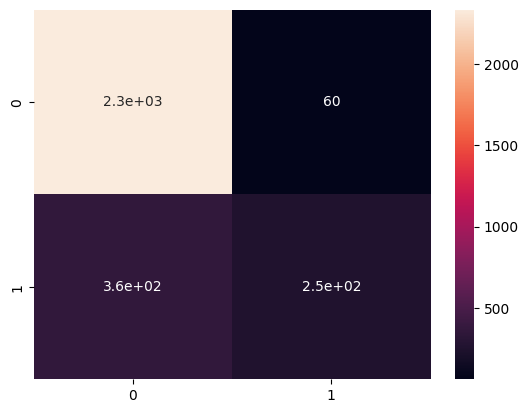

In [9]:
#la matriz anterior se pueed graficar
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)   #annot sirve para ver los valores dentro del gráfico

Existe lo llamado ***Paradoja de de la Precisión***, que indica que el `score`, puede llegar a ser una métrica ambigua

Es ahí donde entran los conceptos de:

* Sensibilidad: tasa de veraderos positivos.
* Especificidad: tasa de verdaderos negativos.

In [10]:
#métricas de la matriz de confusión
#tn = true negative
#fp = false positive
#fn = false negative
#tp = true positive
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(2335, 60, 358, 247)

In [11]:
#sensibilidad
sens = tp/(tp+fn)
#especificidad
espec = tn/(tn+fp)
sens, espec
#esto se interpreta como que: el modelo no es tan bueno prediciendo los 1's, es decir, los clientes que fugan (al rededor del 40%)

(0.40826446280991735, 0.9749478079331941)

In [12]:
#métricas de error
#ET1- tasa de falsos positivos
#ET2- tasa de falsos negativos
ET1 = fp/(tn+fp+fn+tp)
ET2 = fn/(tn+fp+fn+tp)
ET1, ET2    #el 1 deber tener el mínimo valor posible. el 2 debe ser 5% < 20%

(0.02, 0.11933333333333333)

##Curva ROC y AUC

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)     #hay que darle la probabilidad de los y_pred para no obtener valores extraños
fpr, tpr, thresholds

(array([0.        , 0.02505219, 1.        ]),
 array([0.        , 0.40826446, 1.        ]),
 array([inf,  1.,  0.]))

In [14]:
#probabilidades para 0 y 1 para el árbol de decisión
#se obtiene un array de 3000 x 2. Para el cáldulo de la ROC, se necesita un array de 1D
p_pred = model.predict_proba(X_test)
p_pred

array([[0.98511166, 0.01488834],
       [0.88036304, 0.11963696],
       [0.88036304, 0.11963696],
       ...,
       [0.80036799, 0.19963201],
       [0.80036799, 0.19963201],
       [0.907173  , 0.092827  ]])

In [15]:
#se elige la probabilidad de que sea 1 (fuga)
p_pred[:,1]

array([0.01488834, 0.11963696, 0.11963696, ..., 0.19963201, 0.19963201,
       0.092827  ])

In [16]:
p_pred = p_pred[:,1]

In [17]:
#fpr = tasa de falsos positivos = 1 - especificidad = fp/(fp+tn)
#tpr = tasa de verdaderos positivos = sensibilidad = tp/(tp+fn)
fpr, tpr, thresholds = roc_curve(y_test, p_pred, pos_label = 1)     #pos_label = 1 para indicarle que 'fuga' es nuestro valore de interés
fpr, tpr, thresholds

(array([0.00000000e+00, 4.17536534e-04, 1.25260960e-03, 6.26304802e-03,
        6.26304802e-03, 1.33611691e-02, 1.33611691e-02, 1.62839248e-02,
        2.50521921e-02, 5.46972860e-02, 7.26513570e-02, 7.39039666e-02,
        7.55741127e-02, 9.51983299e-02, 1.09812109e-01, 2.62212944e-01,
        3.02296451e-01, 3.27766180e-01, 5.25260960e-01, 6.39665971e-01,
        6.64300626e-01, 7.91231733e-01, 9.99582463e-01, 1.00000000e+00]),
 array([0.        , 0.0661157 , 0.11735537, 0.24793388, 0.25619835,
        0.31404959, 0.31735537, 0.33884298, 0.40826446, 0.50413223,
        0.57190083, 0.57190083, 0.58181818, 0.60661157, 0.61487603,
        0.76033058, 0.77355372, 0.79173554, 0.8892562 , 0.92396694,
        0.94545455, 0.9768595 , 0.99669421, 1.        ]),
 array([       inf, 1.        , 0.95454545, 0.88118812, 0.85714286,
        0.75490196, 0.71428571, 0.68656716, 0.56756757, 0.44200627,
        0.4295302 , 0.35      , 0.31578947, 0.29007634, 0.24817518,
        0.19963201, 0.18376068, 

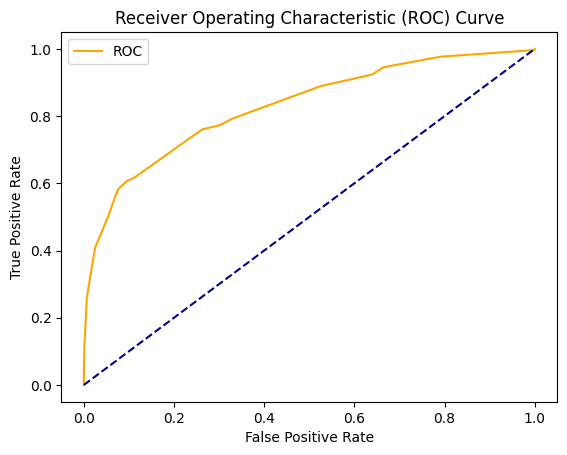

In [18]:
fig = plt.figure()
plt.plot(fpr, tpr, color = 'orange', label = 'ROC')   #falsos positivos VS veraderos positivos
plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')        #esta curva representa un modelo que tiene igual número de aciertos que de errores

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()

In [19]:
#compara el área bajo la curva ROC del modelo estudiado VS el área bajo la curva ROC de un modelo perfecto
auc = roc_auc_score(y_test, p_pred)
auc

0.8289342466226124

##GINI

In [20]:
GINI = 2*auc-1
GINI

0.6578684932452248

#Reporte de Métricas

In [21]:
#predict_proba is not available when  probability=False...........este error lo da el SVM, por lo que se tendrá que quitar del código
'''
model_accu = []     #lista scores
model_sens = []     #lista de sensibilidades
model_espec = []    #lista de especificidades
model_ET1 = []      #errores 1
model_ET2 = []      #errores 2
model_auc = []      #lista AUC's
model_gini = []     #lista GINI's

for model in models_list_object:
  model.fit(X_train, y_train)               #entrena cada modelo

  y_pred = model.predict(X_test)            #predice las y con cada modelo
  p_pred = model.predict_proba(X_test)      #predice laas probabilidades de cada y_pred con cada modelo
  p_pred = p_pred[:,1]                      #pasar la p_pred a arreglo lineal, solo la columna 1, la de los unos

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  sens = tp/(tp+fn)
  espec = tn/(tn+fp)
  ET1 = fp/(tn+fp+fn+tp)
  ET2 = fn/(tn+fp+fn+tp)

  auc = roc_auc_score(y_test, p_pred)
  GINI = 2*auc-1

  model_accu.append(metrics.accuracy_score(y_test, y_pred))   #calcula el éxito de cada modelo y lo guarda en la lista
  model_sens.append(sens)
  model_espec.append(espec)
  model_ET1.append(ET1)
  model_ET2.append(ET2)
  model_auc.append(auc)
  model_gini.append(GINI)
  '''

"\nmodel_accu = []     #lista scores\nmodel_sens = []     #lista de sensibilidades\nmodel_espec = []    #lista de especificidades\nmodel_ET1 = []      #errores 1\nmodel_ET2 = []      #errores 2\nmodel_auc = []      #lista AUC's\nmodel_gini = []     #lista GINI's\n\nfor model in models_list_object:\n  model.fit(X_train, y_train)               #entrena cada modelo\n\n  y_pred = model.predict(X_test)            #predice las y con cada modelo\n  p_pred = model.predict_proba(X_test)      #predice laas probabilidades de cada y_pred con cada modelo\n  p_pred = p_pred[:,1]                      #pasar la p_pred a arreglo lineal, solo la columna 1, la de los unos\n  \n  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()\n  sens = tp/(tp+fn)\n  espec = tn/(tn+fp)\n  ET1 = fp/(tn+fp+fn+tp)\n  ET2 = fn/(tn+fp+fn+tp)\n\n  auc = roc_auc_score(y_test, p_pred)\n  GINI = 2*auc-1\n\n  model_accu.append(metrics.accuracy_score(y_test, y_pred))   #calcula el éxito de cada modelo y lo guarda en la lis

In [22]:
model_accu = []     #lista scores
model_sens = []     #lista de sensibilidades
model_espec = []    #lista de especificidades
model_ET1 = []      #errores 1
model_ET2 = []      #errores 2
model_auc = []      #lista AUC's
model_gini = []     #lista GINI's

for model in models_list_object[:-1]:       #se tuvo que sacar el SVM porque proba daba False y eso provocaba un error
  model.fit(X_train, y_train)               #entrena cada modelo

  y_pred = model.predict(X_test)            #predice las y con cada modelo
  p_pred = model.predict_proba(X_test)      #predice laas probabilidades de cada y_pred con cada modelo
  p_pred = p_pred[:,1]                      #pasar la p_pred a arreglo lineal, solo la columna 1, la de los unos

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  sens = tp/(tp+fn)
  espec = tn/(tn+fp)
  ET1 = fp/(tn+fp+fn+tp)
  ET2 = fn/(tn+fp+fn+tp)

  auc = roc_auc_score(y_test, p_pred)
  GINI = 2*auc-1

  model_accu.append(metrics.accuracy_score(y_test, y_pred))   #calcula el éxito de cada modelo y lo guarda en la lista
  model_sens.append(sens)
  model_espec.append(espec)
  model_ET1.append(ET1)
  model_ET2.append(ET2)
  model_auc.append(auc)
  model_gini.append(GINI)


In [23]:
#concentrado de métricas
pd.DataFrame({'Models':models_list_name[:-1],
              'Accuracy':model_accu,
              'Sesibilty':model_sens,
              'Especificity':model_espec,
              'Error T1':model_ET1,
              'Error T2':model_ET2,
              'AUC':model_auc,
              'GINI':model_gini})

,Models,Accuracy,Sesibilty,Especificity,Error T1,Error T2,AUC,GINI
0,LogisticRegression,0.819000,0.209917,0.972860,0.021667,0.159333,0.779978,0.559957
1,DecisionTreeClassifier,0.860667,0.408264,0.974948,0.020000,0.119333,0.828944,0.657889
2,RandomForestClassifier,0.847000,0.388430,0.962839,0.029667,0.123333,0.802304,0.604607


In [24]:
models_list_object

[LogisticRegression(),
 DecisionTreeClassifier(max_depth=5),
 RandomForestClassifier(n_estimators=6),
 SVC()]

In [25]:
#mejor modelo/exportación
#se elige el árbol de decisión por un menor Error tipo 1, mayor AUC y mayor GINI
import pickle as pkl
modelo = DecisionTreeClassifier(max_depth=5)
modelo.fit(X_train, y_train)
pkl.dump(modelo, open('Modelo_Churn_Final.pkl', 'wb'))

In [27]:
modelo.feature_names_in_

array(['Tenure', 'IsActiveMember', 'Balance_esc', 'EstimatedSalary_Esc',
       'Gender', 'Age_esc', 'Geography', 'HasCrCard', 'CreditScore_esc',
       'NumOfProducts'], dtype=object)